In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass
from gemseo import configure_logger
from gemseo.disciplines.auto_py import AutoPyDiscipline
from gemseo.algos.parameter_space import ParameterSpace
from gemseo import from_pickle
from gemseo.algos.design_space import DesignSpace
from gemseo_oad_training.unit import convert_from
from gemseo_umdo.scenarios.umdo_scenario import UMDOScenario
from gemseo_umdo.formulations.sampling_settings import Sampling_Settings
from gemseo_oad_training.utils import draw_aircraft
from gemseo_oad_training.utils import AircraftConfiguration

configure_logger()

<RootLogger root (INFO)>

In [2]:
# On veut résoudre le problème 1 avec UC1 et UC2
disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

In [3]:
# Create the design space
design_space = DesignSpace()
design_space.add_variable('slst', lower_bound=100000.0, upper_bound=200000.0, value=150000.0)
design_space.add_variable('n_pax', lower_bound=120, upper_bound=180, value=150)
design_space.add_variable('area', lower_bound=100, upper_bound=200, value=180)
design_space.add_variable('ar', lower_bound=5, upper_bound=20, value=9)

In [4]:
uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)

In [5]:
scenario = UMDOScenario(
    disciplines,
    "mtom",
    design_space,
    uncertain_space,
    objective_statistic_name="Mean",
    formulation_name="MDF",
    statistic_estimation_settings=Sampling_Settings(
        n_samples=100, estimate_statistics_iteratively=False
    ),
)

In [6]:
# Add the constraints
scenario.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True, statistic_name="Margin", factor=-2.0)
scenario.add_constraint('span', constraint_type='ineq', value=40.0, positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('length', constraint_type='ineq', value=45.0, positive=False, statistic_name="Margin", factor=2.0)
scenario.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True, statistic_name="Margin", factor=-2.0)

In [7]:
scenario.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    INFO - 12:07:49: *** Start UMDOScenario execution ***
    INFO - 12:07:49: UMDOScenario
    INFO - 12:07:49:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 12:07:49:    Formulation:
    INFO - 12:07:49:       MDO formulation: MDF
    INFO - 12:07:49:       Statistic estimation: Sampling
    INFO - 12:07:49:    Uncertain space:
    INFO - 12:07:49:       +------+--------------------------------------------+
    INFO - 12:07:49:       | Name |                Distribution                |
    INFO - 12:07:49:       +------+--------------------------------------------+
    INFO - 12:07:49:       | aef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 12:07:49:       | cef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 12:07:49:       | sef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 12:07:49:       +------+--------------------------------------------+
    INFO - 

In [8]:
# scenario.post_process(post_name="OptHistoryView", save=False, show=True)

In [8]:
result = scenario.optimization_result
(result.constraint_values)

{'[Margin[tofl; 2.0]-1900.0]': array([4.46255858e-05]),
 '[Margin[vapp; 2.0]-69.44999999400001]': array([-3.52932442]),
 '-[Margin[vz; -2.0]-1.524]': array([-2.94745688]),
 '[Margin[span; 2.0]-40.0]': array([-4.28286739e-10]),
 '[Margin[length; 2.0]-45.0]': array([-13.]),
 '-Margin[fm; -2.0]': array([-0.53168864])}

In [9]:
import pandas as pd
import numpy as np

constraints = {
    'tofl': {'seuil': 1900.0, 'factor': 2.0, 'positive': False},
    'vapp': {'seuil': 69.45, 'factor': 2.0, 'positive': False},
    'vz': {'seuil': 1.524, 'factor': -2.0, 'positive': True},
    'span': {'seuil': 40.0, 'factor': 2.0, 'positive': False},
    'length': {'seuil': 45.0, 'factor': 2.0, 'positive': False},
    'fm': {'seuil': 0.0, 'factor': -2.0, 'positive': True},
}


margins = {
    'tofl': 4.46255858e-05,
    'vapp': -3.52932442,
    'vz': -2.94745688,
    'span': -4.28286739e-10,
    'length': -13.0,
    'fm': -0.53168864,
}

data = []

for key, params in constraints.items():
    M = margins[key]
    s = params['seuil']
    f = abs(params['factor'])
    pos = params['positive']

    if pos:
        v = s - M / f
    else:
        v = s + M / f

    status = 'Respectée' if M < 0 else 'Non respectée'

    data.append({
        'Contrainte': key,
        'Seuil': s,
        'Facteur abs': f,
        'Marge standardisée': M,
        'Valeur réelle': v,
        'Statut': status
    })

df = pd.DataFrame(data)
df.head(6)


,Contrainte,Seuil,Facteur abs,Marge standardisée,Valeur réelle,Statut
0,tofl,1900.000,2.0,4.462559e-05,1900.000022,Non respectée
1,vapp,69.450,2.0,-3.529324e+00,67.685338,Respectée
2,vz,1.524,2.0,-2.947457e+00,2.997728,Respectée
3,span,40.000,2.0,-4.282867e-10,40.000000,Respectée
4,length,45.000,2.0,-1.300000e+01,38.500000,Respectée
5,fm,0.000,2.0,-5.316886e-01,0.265844,Respectée


# Import surrogate model

In [11]:
surrogate_disciplines = from_pickle("my_surrogate_3.pkl")
surrogate_disciplines

Surrogate discipline: RBF_Sampling
   Dataset name: Sampling
   Dataset size: 28
   Surrogate model: RBFRegressor
   Inputs: aef, ar, area, cef, n_pax, sef, slst
   Outputs: fm, length, mtom, span, tofl, vapp, vz
   Linearization mode: auto

# create a new design space


In [12]:
design_space_surrogate = DesignSpace()
design_space_surrogate.add_variable('slst', lower_bound=100000.0, upper_bound=200000.0, value=150000.0)
design_space_surrogate.add_variable('n_pax', lower_bound=120, upper_bound=180, value=150)
design_space_surrogate.add_variable('area', lower_bound=100, upper_bound=200, value=180)
design_space_surrogate.add_variable('ar', lower_bound=5, upper_bound=20, value=9)

In [13]:
uncertain_space_surrogate = ParameterSpace()
uncertain_space_surrogate.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space_surrogate.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space_surrogate.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)

In [14]:
scenario_surrogate = UMDOScenario(
    [surrogate_disciplines],
    "mtom",
    design_space_surrogate,
    uncertain_space_surrogate,
    objective_statistic_name="Mean",
    formulation_name="MDF",
    statistic_estimation_settings=Sampling_Settings(
        n_samples=100, estimate_statistics_iteratively=False
    ),
)

 WARNING - 13:42:45: No coupling in MDA, switching chain_linearize to True.
 WARNING - 13:42:45: No coupling in MDA, switching chain_linearize to True.


In [15]:
# Add the constraints
scenario_surrogate.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True, statistic_name="Margin", factor=-2.0)
scenario_surrogate.add_constraint('span', constraint_type='ineq', value=40.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('length', constraint_type='ineq', value=45.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_surrogate.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True, statistic_name="Margin", factor=-2.0)

In [16]:
scenario_surrogate.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    INFO - 13:42:57: *** Start UMDOScenario execution ***
    INFO - 13:42:57: UMDOScenario
    INFO - 13:42:57:    Disciplines: RBF_Sampling
    INFO - 13:42:57:    Formulation:
    INFO - 13:42:57:       MDO formulation: MDF
    INFO - 13:42:57:       Statistic estimation: Sampling
    INFO - 13:42:57:    Uncertain space:
    INFO - 13:42:57:       +------+--------------------------------------------+
    INFO - 13:42:57:       | Name |                Distribution                |
    INFO - 13:42:57:       +------+--------------------------------------------+
    INFO - 13:42:57:       | aef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 13:42:57:       | cef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 13:42:57:       | sef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 13:42:57:       +------+--------------------------------------------+
    INFO - 13:42:57: Optimization problem:
    INFO - 13:42:57:    minimize E[mtom]
    INFO - 13:42:57:   

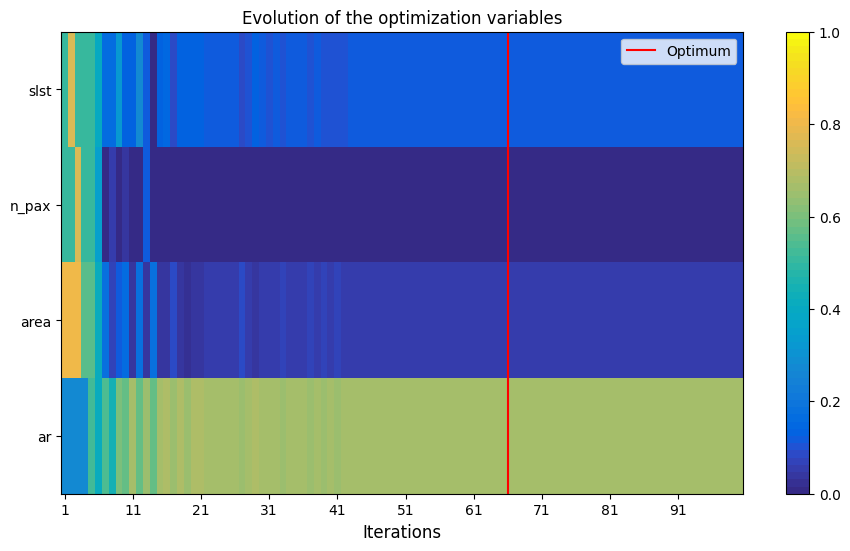

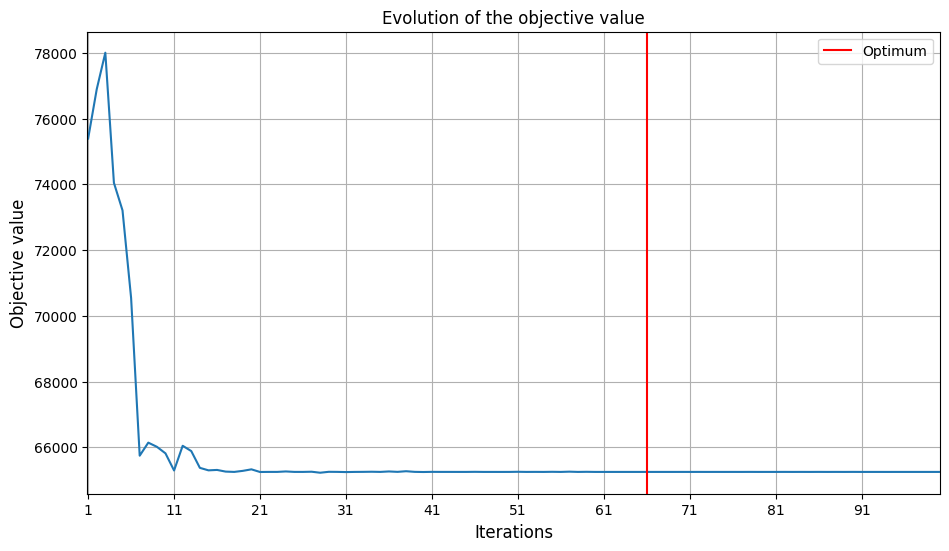

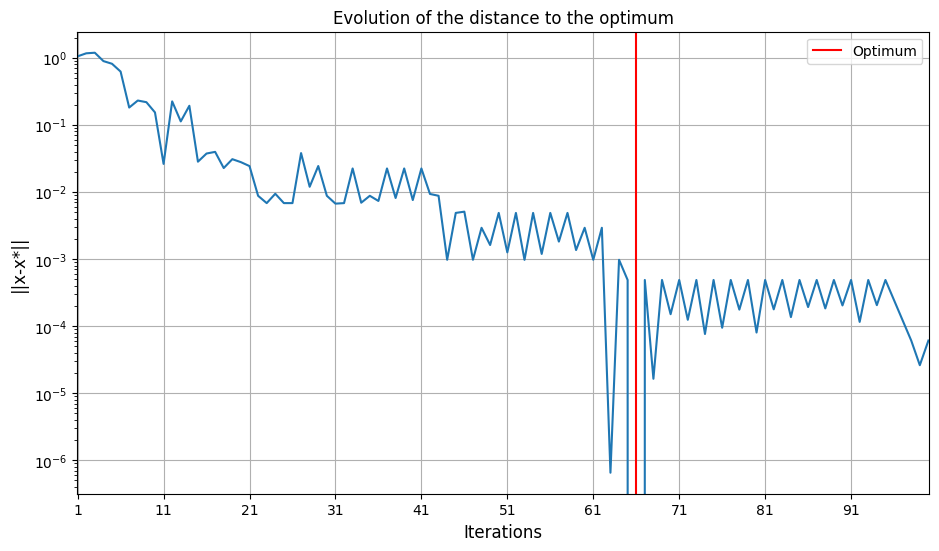

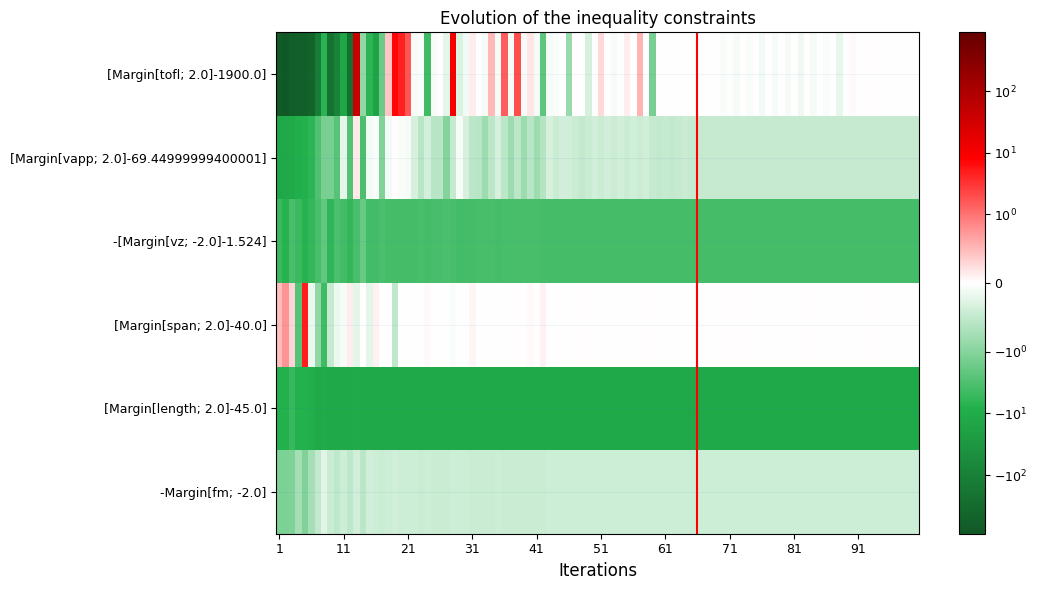

In [17]:
scenario_surrogate.post_process(post_name="OptHistoryView", save=False, show=True)

# Evaluate surrogate optimum in the original model

## Compare results

In [18]:
scenario.optimization_result.x_opt_as_dict

{'slst': array([100000.]),
 'n_pax': array([120.]),
 'area': array([113.08177607]),
 'ar': array([14.14905262])}

## Evaluate optimum

In [19]:
scenario_surrogate.optimization_result.x_opt_as_dict

{'slst': array([111346.34623666]),
 'n_pax': array([120.]),
 'area': array([105.29592113]),
 'ar': array([14.93743494])}

In [20]:
scenario_test = UMDOScenario(
    disciplines,
    "mtom",
    design_space,
    uncertain_space,
    objective_statistic_name="Mean",
    formulation_name="MDF",
    statistic_estimation_settings=Sampling_Settings(
        n_samples=100, estimate_statistics_iteratively=False
    ),
)

In [21]:
# Add the constraints
scenario_test.add_constraint('tofl', constraint_type='ineq', value=1900.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('vapp', constraint_type='ineq', value=convert_from("kt",135.0), positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('vz', constraint_type='ineq', value=convert_from("ft/min",300.0), positive=True, statistic_name="Margin", factor=-2.0)
scenario_test.add_constraint('span', constraint_type='ineq', value=40.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('length', constraint_type='ineq', value=45.0, positive=False, statistic_name="Margin", factor=2.0)
scenario_test.add_constraint('fm', constraint_type='ineq', value=0.0, positive=True, statistic_name="Margin", factor=-2.0)

In [22]:
scenario_test.execute(algo_name = 'CustomDOE', samples = [scenario_surrogate.optimization_result.x_opt_as_dict])

    INFO - 13:44:03: *** Start UMDOScenario execution ***
    INFO - 13:44:03: UMDOScenario
    INFO - 13:44:03:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 13:44:03:    Formulation:
    INFO - 13:44:03:       MDO formulation: MDF
    INFO - 13:44:03:       Statistic estimation: Sampling
    INFO - 13:44:03:    Uncertain space:
    INFO - 13:44:03:       +------+--------------------------------------------+
    INFO - 13:44:03:       | Name |                Distribution                |
    INFO - 13:44:03:       +------+--------------------------------------------+
    INFO - 13:44:03:       | aef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 13:44:03:       | cef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 13:44:03:       | sef  | Triangular(lower=0.99, mode=1, upper=1.03) |
    INFO - 13:44:03:       +------+--------------------------------------------+
    INFO - 

# Draw aircrafts

In [5]:
constraint_values = scenario.optimization_result.constraint_values
constraint_values_surrogate = scenario_surrogate.optimization_result.constraint_values

print("Constraints values for the original scenario:")
for name, value in constraint_values.items():
    print(f"{name}: {value}")
print("\nConstraints values for the surrogate scenario:")
for name, value in constraint_values_surrogate.items():
    print(f"{name}: {value}")

NameError: name 'scenario' is not defined

In [21]:
AC1 =AircraftConfiguration(name = 'x_base', length= 24.50, span = 26.37, area = 115.78, color = 'blue')
AC2 =AircraftConfiguration(name = 'x_surrogate', length= 24.50, span = 31.66, area = 120.07, color = 'orange')
AC3 =AircraftConfiguration(name = 'x_default', length= 35.42, span = 35.96, area = 180, color = 'green')

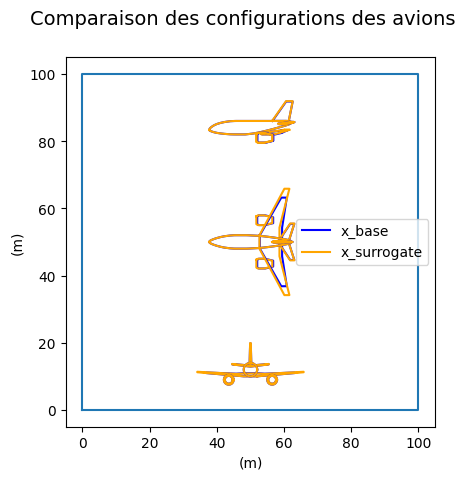

In [22]:
draw_aircraft(AC1, AC2, title="Comparaison des configurations des avions", save=False, show=True)

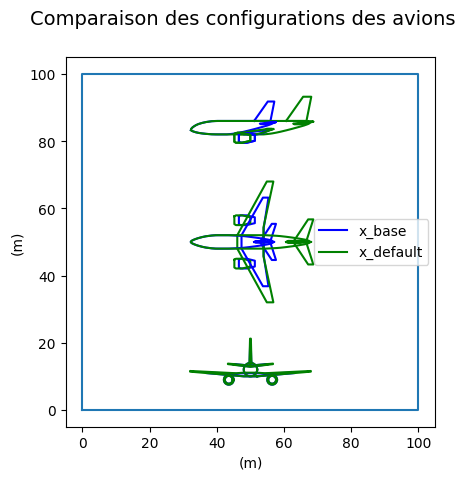

In [23]:
draw_aircraft(AC1, AC3, title="Comparaison des configurations des avions", save=False, show=True)